TODO

-   weekly performance, only show best model, weeks 0 to 20
-   run variations of prediction window (lookahead) + frequency, plot of sensitivity by frequency/lookahead
-   sensitivity + specificity + AUC+ROC
-   do weekly versions + trendline, not cum
-   for manuscript -- use terms e.g., "scheduled retraining", "closed loop"
-   why even do online learning -- capture "in situ" context, don't simply apply historical model to new cohort
-   experiment with oversampling recent data (or sample weighting, focus on the positive observations)
    -   look into regret minimization algos


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_83254/2033846779.py:7: DtypeWarning: Columns (32,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [3]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    df["ActivityDateTime"] = pd.to_datetime(df["ActivityDateTime"])
    df["therapy_week"] = df.groupby("dyad")["ActivityDateTime"].transform(
        lambda x: (x - x.min()).dt.days // 7
    )

    # Select features
    df = df.drop(
        [
            "DurationInSeconds",  # total active time
            "SleepMorningDate",
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            # "hr_moving_avg_10m",
            # "hr_moving_std_10m",
            # "hr_moving_min_10m",
            # "hr_moving_max_10m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_60m",
            "hr_moving_std_60m",
            "hr_moving_min_60m",
            "hr_moving_max_60m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df


def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "ActivityDateTime",
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "Arm_Sham",
            "dyad",
            "therapy_week",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y

In [4]:
from sklearn.model_selection import train_test_split

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = clean_data(sorted_dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=False)
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_83254/658511871.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [24]:
from sklearn.base import BaseEstimator


class HrModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_10m"]
        return (mean_hr > 80) & (mean_hr < 129)

    def predict_proba(self, X):
        preds = self.predict(X)
        proba = np.zeros((len(X), 2))
        proba[:, 1] = preds.astype(float)
        proba[:, 0] = 1 - proba[:, 1]
        return proba

In [7]:
cleaned_dyads_df = clean_data(dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_83254/658511871.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [15]:
from flaml import AutoML
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit()
automl = AutoML()


automl_settings = {
    "time_budget": 15,  # seconds
    "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 12-17 13:46:49] {1752} INFO - task = classification
[flaml.automl.logger: 12-17 13:46:49] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-17 13:46:49] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 12-17 13:46:49] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-17 13:46:49] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-17 13:46:49] {2417} INFO - Estimated sufficient time budget=5206s. Estimated necessary time budget=5s.
[flaml.automl.logger: 12-17 13:46:49] {2466} INFO -  at 0.9s,	estimator xgboost's best error=0.0252,	best estimator xgboost's best error=0.0252
[flaml.automl.logger: 12-17 13:46:49] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-17 13:46:49] {2466} INFO -  at 0.9s,	estimator xgboost's best error=0.0252,	best estimator xgboost's best error=0.0252
[flaml.automl.logger: 12-17 13:46:49] {2282} INFO - iteration 2, cur

-   Task = predict tantrum within 60m
-   Test = 15m, 30m, 60m period


In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

positive_model = DummyClassifier(strategy="constant", constant=1).fit(X_train, y_train)
hr_model = y_hat_hr = HrModel()
model = automl

df_test_60m = df_test[df_test["ActivityDateTime"].dt.minute.isin([0])]
df_test_30m = df_test[df_test["ActivityDateTime"].dt.minute.isin([0, 30])]

for label, df in [
    ("15m", df_test),
    ("30m", df_test_30m),
    ("60m", df_test_60m),
]:
    print(f"Evaluating for prediction frequency: {label}")
    X_test, y_test = prep_X_y(df, "tantrum_within_60m")

    y_hat_positive = positive_model.predict(X_test)
    print(
        f"Positive Model (Control) ROC-AUC: {roc_auc_score(y_test, y_hat_positive):.4f}"
    )

    y_hat_hr = hr_model.predict_proba(X_test)
    print(f"HR Model ROC-AUC: {roc_auc_score(y_test, y_hat_hr[:, 1]):.4f}")

    y_hat = model.predict_proba(X_test)
    print(f"XGB ROC-AUC: {roc_auc_score(y_test, y_hat[:, 1]):.4f}")
    print()

Evaluating for prediction frequency: 15m
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5220
XGB ROC-AUC: 0.7061

Evaluating for prediction frequency: 30m
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5268
XGB ROC-AUC: 0.7018

Evaluating for prediction frequency: 60m
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5148
XGB ROC-AUC: 0.6952



Now, fix frequency at 15m and test 15m, 30m, 60m lookahead windows


In [35]:
for window in ["15m", "30m", "60m"]:
    print(f"Evaluating for lookahead window: {window}")
    X_test, y_test = prep_X_y(df, response_column=f"tantrum_within_{window}")
    print(f"Total positive samples: {y_test.sum()} out of {len(y_test)}")

    y_hat = model.predict_proba(X_test)
    y_hat_positive = positive_model.predict(X_test)
    y_hat_hr = hr_model.predict_proba(X_test)
    y_hat = model.predict_proba(X_test)

    print(
        f"Positive Model (Control) ROC-AUC: {roc_auc_score(y_test, y_hat_positive):.4f}"
    )
    print(f"HR Model ROC-AUC: {roc_auc_score(y_test, y_hat_hr[:, 1]):.4f}")
    print(f"XGB ROC-AUC: {roc_auc_score(y_test, y_hat[:, 1]):.4f}")
    print()


Evaluating for lookahead window: 15m
Total positive samples: 50 out of 63965
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5133
XGB ROC-AUC: 0.6900

Evaluating for lookahead window: 30m
Total positive samples: 81 out of 63965
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5081
XGB ROC-AUC: 0.7133

Evaluating for lookahead window: 60m
Total positive samples: 154 out of 63965
Positive Model (Control) ROC-AUC: 0.5000
HR Model ROC-AUC: 0.5148
XGB ROC-AUC: 0.6952



In [36]:
import shap
from xgboost import XGBClassifier

# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
# Fit the model if not already fitted

model = XGBClassifier(**automl.best_config)
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

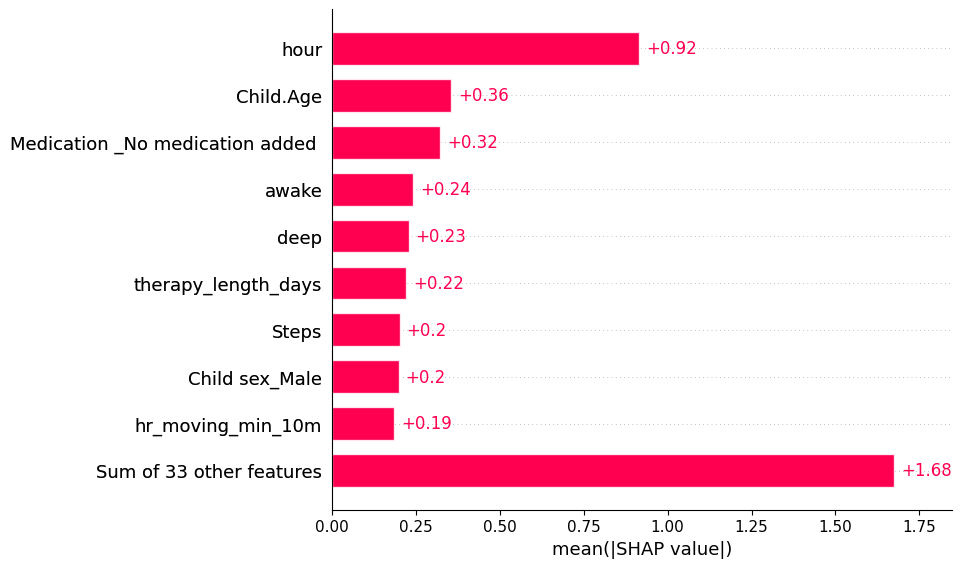

In [37]:
shap.plots.bar(shap_values)

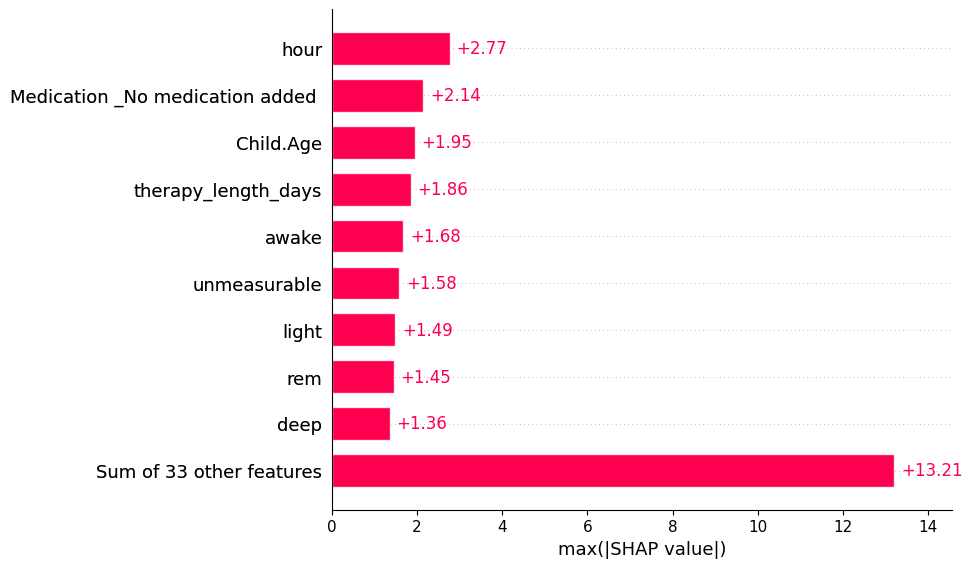

In [39]:
# Absolute max value highlights features that have infrequent but strong impacts
shap.plots.bar(shap_values.abs.max(0))

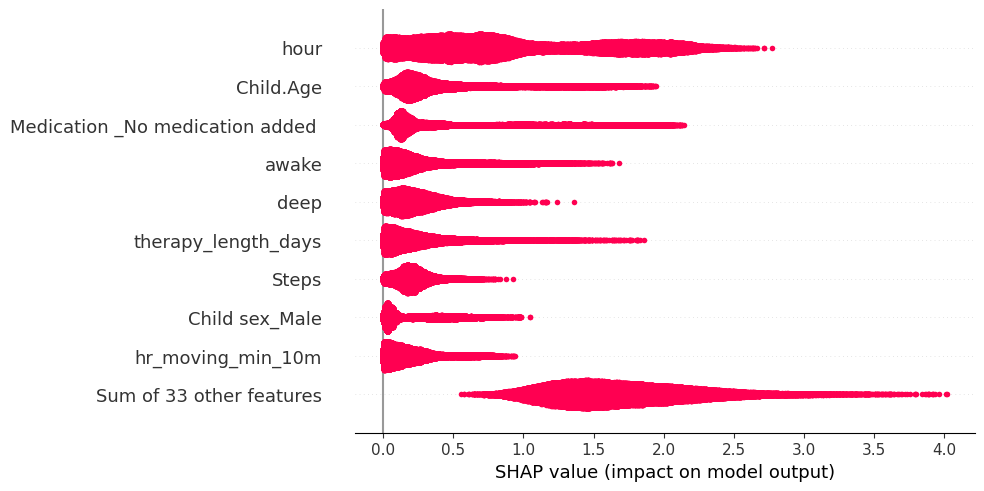

In [40]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")